In [1]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
from scipy.stats import mannwhitneyu
import h5py

INFO:numexpr.utils:Note: detected 192 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 192 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [76]:
SRP_name = 'aggregates'
resolution = '10kbp_raw' 
species= 'mouse'
marker_level='cluster'

In [77]:
input_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/max/'
bins_bed = pd.read_csv(f'{input_path}/all_bins.bed', names=['chr', 'start', 'end', 'bin_id'])
bins_bed['bin_id'] = bins_bed.index
bins_bed['pos'] = bins_bed['chr'] + '_' + bins_bed['start'].astype('str')

In [78]:
for filename, col_names, filepath in zip(['BICCN2'], [['AC','EX','IN','OG','OT']], ['output_BICCN2_gene_global_index__all_scanpy_obj_clust_ave_celltype.bed']):

    

    atac_file_path= f"/grid/gillis/data/lohia/ATAC_Risa/celltype/{filepath}"
    
    
    comple_col = ['chr', 'start', 'end']
    
    comple_col.extend(col_names)
    
    print (comple_col)

    df = pd.read_csv(atac_file_path, sep='\t|,', skiprows=1, names=comple_col)
    
    print (df)
    
    df['start_bin'] = df['start'] / 10000


    df['end_bin'] = df['end'] / 10000

    df['start_bin'] = df['start_bin'].astype(int)
    df['end_bin'] = df['end_bin'].astype(int)
    
    
    df['start_bin'] = df['start_bin']*10000
    df['end_bin'] = df['end_bin']*10000
   

    df_atac = df.groupby(['chr','start_bin'])[col_names].sum().reset_index()
    
    df_atac['chr'] = df_atac['chr'].astype('str')
    df_atac['chr'] = 'chr' + df_atac['chr']

    df_atac['start_bin'] = df_atac['chr'] + '_'+df_atac['start_bin'].astype(str) 
    
    

['chr', 'start', 'end', 'AC', 'EX', 'IN', 'OG', 'OT']


<ipython-input-78-17644e80d271>:14: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(atac_file_path, sep='\t|,', skiprows=1, names=comple_col)


        chr      start        end        AC        EX        IN        OG  \
0         X    3052001    3053000  0.000139  0.000000  0.000000  0.000000   
1         X    3053001    3054000  0.000139  0.000000  0.000000  0.000000   
2         X    3054001    3055000  0.000139  0.000000  0.000000  0.000000   
3         X    3057001    3058000  0.000277  0.000000  0.000000  0.000000   
4         X    3058001    3059000  0.000139  0.000000  0.000000  0.000000   
...      ..        ...        ...       ...       ...       ...       ...   
2466671   8  129297001  129298000  0.000139  0.000923  0.000336  0.000000   
2466672   8  129298001  129299000  0.000139  0.001160  0.000224  0.000169   
2466673   8  129299001  129300000  0.000139  0.001705  0.000224  0.000169   
2466674   8  129300001  129301000  0.000832  0.001539  0.000783  0.000253   
2466675   8  129301001  129302000  0.000139  0.000308  0.000000  0.000000   

               OT  
0        0.000000  
1        0.000000  
2        0.0000

In [79]:
df_cre_1kb_end = df_atac.merge(bins_bed, left_on='start_bin', right_on='pos')

In [80]:
input_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/'
bins_bed = pd.read_csv(f'{input_path}/all_bins.bed', names=['chr', 'start', 'end', 'bin_id'])
bins_bed['bin_id'] = bins_bed.index
  
chr_list = bins_bed.drop_duplicates(subset=['chr'])['chr'].tolist()
chrom_index_list = {}
for chrom in chr_list:
      st = bins_bed[bins_bed['chr'] == chrom]['bin_id'].tolist()[0]
      en = bins_bed[bins_bed['chr'] == chrom]['bin_id'].tolist()[-1]
      chrom_index_list[chrom] = list(range(st, en+1))
gene_bed = pd.read_csv(f'{input_path}/all_gene.bed', names=['chr', 'start_bin', 'end_bin', 'gene'])



In [105]:
marker_level='class'
number_of_genes='1000'

with h5py.File(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/{marker_level}_{number_of_genes}_contacts_gene_nor_all_back.h5', 'r') as hf:
                   
        my_data = hf['type_contacts'][()]
        type_list = hf['type_list'][()]
        column_list = hf['column_list'][()]




df_max_gene_inter_by_bins_tmp = pd.DataFrame(my_data, index=[x.decode() for x in type_list.tolist()], columns = column_list.tolist())
#df_max_gene_inter_by_bins['group'] = [x.decode() for x in type_list.tolist()]


#df_max_gene_inter_by_bins_sum_mean = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/background_mean_gene_nor_all_back.csv')


df_concat_list_mean_nn_by_bins_normalized = df_max_gene_inter_by_bins_tmp


In [106]:
df_max_gene_inter_by_bins = df_concat_list_mean_nn_by_bins_normalized.T
df_max_gene_inter_by_bins['bin_id'] = df_max_gene_inter_by_bins.index.tolist()

In [135]:
marker_level='class'
number_of_genes='1000'

with h5py.File(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/{marker_level}_{number_of_genes}_p_val_gene_nor_all_back_GABAergic_vs_Glutamatergic_{marker_level}.h5', 'r') as hf:
                   
        my_data = hf['type_contacts'][()]
        type_list = hf['type_list'][()]
        column_list = hf['column_list'][()]




df_max_gene_inter_by_bins_gaba = pd.DataFrame(my_data, columns=[type_list.decode()], index = column_list.tolist())


with h5py.File(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/{marker_level}_{number_of_genes}_p_val_gene_nor_all_back_Glutamatergic_vs_GABAergic_{marker_level}.h5', 'r') as hf:
                   
        my_data = hf['type_contacts'][()]
        type_list = hf['type_list'][()]
        column_list = hf['column_list'][()]




df_max_gene_inter_by_bins_gluta = pd.DataFrame(my_data, columns=[type_list.decode()], index = column_list.tolist())


#df_max_gene_inter_by_bins['group'] = [x.decode() for x in type_list.tolist()]


#df_max_gene_inter_by_bins_sum_mean = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/background_mean_gene_nor_all_back.csv')


#df_max_gene_inter_by_bins = df_max_gene_inter_by_bins_tmp

#df_concat_list_mean_nn_by_bins_normalized = df_max_gene_inter_by_bins_tmp.div(df_max_gene_inter_by_bins_sum_mean['0'], axis=1)


In [136]:
df_cre_tog = df_cre_1kb_end.merge(df_max_gene_inter_by_bins)

In [137]:
#df_cre_tog['hic'] =  df_cre_tog['Glutamatergic'] - df_cre_tog['GABAergic']

#df_cre_tog['hic_x'] = df_cre_tog['GABAergic_x'] - df_cre_tog['Glutamatergic_x']

df_cre_tog['nn'] = [((a+b+c)/3) for a,b,c in zip(df_cre_tog['AC'].tolist(), df_cre_tog['OG'].tolist(), df_cre_tog['OT'].tolist())]

df_cre_tog['n'] = df_cre_tog['IN'] + df_cre_tog['EX']

df_cre_tog['exp'] = df_cre_tog['IN'] - df_cre_tog['EX']

df_cre_tog_sel = pd.concat([df_cre_tog[df_cre_tog['EX'] == 0], df_cre_tog[df_cre_tog['IN'] == 0]]).drop_duplicates(keep=False)

df_cre_tog_sel = df_cre_tog_sel[~( (df_cre_tog_sel['EX']==0) & (df_cre_tog_sel['IN']==0))]
#df_cre_tog_sel  = df_cre_tog
#df_cre_tog_sel = pd.concat([df_cre_tog_sel[df_cre_tog_sel['Glutamatergic'] <= 1], df_cre_tog_sel[df_cre_tog_sel['GABAergic'] <= 1]]).drop_duplicates(keep=False)
df_max_gene_inter_by_bins_gluta['bin_id'] = df_max_gene_inter_by_bins_gluta.index
df_max_gene_inter_by_bins_gaba['bin_id'] = df_max_gene_inter_by_bins_gaba.index
#df_max_gene_inter_by_bins_gluta_nn['bin_id'] = df_max_gene_inter_by_bins_gluta_nn.index
df_cre_tog_sel = df_cre_tog_sel.merge(df_max_gene_inter_by_bins_gluta, left_on=['bin_id'], right_on=['bin_id'])

df_cre_tog_sel = df_cre_tog_sel.merge(df_max_gene_inter_by_bins_gaba, left_on=['bin_id'], right_on=['bin_id'])

#df_cre_tog_sel = df_cre_tog_sel.merge(df_max_gene_inter_by_bins_gluta_nn, left_on=['bin_id'], right_on=['bin_id'])

#df_cre_tog_sel = pd.concat([df_cre_tog_sel[df_cre_tog_sel['Glutamatergic_x'] == 0], df_cre_tog_sel[df_cre_tog_sel['GABAergic_x'] == 0]]).drop_duplicates(keep=False)

#df_cre_tog_sel = df_cre_tog_sel[~( (df_cre_tog_sel['Glutamatergic_x']==0) & (df_cre_tog_sel['GABAergic_x']==0))]
#df_cre_tog_sel = df_cre_tog_sel[~( (df_cre_tog_sel['Glutamatergic']>1) & (df_cre_tog_sel['GABAergic']==0))]

In [54]:
%matplotlib inline
import seaborn as sns

In [35]:
df_cre_tog_sel

chr_x        start_bin        AC        EX        IN        OG  \
0     chr10   chr10_81770000  0.000000  0.000000  0.000112  0.000000   
1     chr10   chr10_81800000  0.000139  0.000000  0.000112  0.000000   
2     chr10   chr10_81840000  0.000000  0.000000  0.000112  0.000169   
3     chr10  chr10_118330000  0.000000  0.000000  0.000112  0.000000   
4     chr11   chr11_83160000  0.000000  0.000000  0.000112  0.000000   
...     ...              ...       ...       ...       ...       ...   
1442   chr9    chr9_89340000  0.000000  0.000047  0.000000  0.000000   
1443   chr9    chr9_89350000  0.000000  0.000024  0.000000  0.000000   
1444   chr9   chr9_109300000  0.000000  0.000024  0.000000  0.000000   
1445   chr9   chr9_114280000  0.000000  0.000071  0.000000  0.000084   
1446   chr9   chr9_121220000  0.000000  0.000947  0.000000  0.000000   

            OT  chr_y      start        end  bin_id              pos  \
0     0.000000  chr10   81770000   81780000  175669   chr10_81770000   
1     0.000091  chr10   81800000   81810000  175672   chr10_81800000   
2     0.000000  chr10   81840000   81850000  175676   chr10_81840000   
3     0.000000  chr10  118330000  118340000  179325  chr10_118330000   
4     0.000000  chr11   83160000   83170000  189188   chr11_83160000   
...        ...    ...        ...        ...     ...              ...   
1442  0.000000   chr9   89340000   89350000  162586    chr9_89340000   
1443  0.000000   chr9   89350000   89360000  162587    chr9_89350000   
1444  0.000000   chr9  109300000  109310000  164582   chr9_109300000   
1445  0.000000   chr9  114280000  114290000  165080   chr9_114280000   
1446  0.000273   chr9  121220000  121230000  165774   chr9_121220000   

      GABAergic_x  Glutamatergic_x  Non-Neuronal        nn         n  \
0        1.123429         1.127703      1.177587  0.000000  0.000112   
1        1.333453         1.348930      1.424456  0.000077  0.000112   
2        1.416668         1.468982      1.540772  0.000056  0.000112   
3        0.811586         0.820007      0.790116  0.000000  0.000112   
4        0.025061         0.031774      0.023829  0.000000  0.000112   
...           ...              ...           ...       ...       ...   
1442     1.374174         1.343314      1.371890  0.000000  0.000047   
1443     1.159842         1.172689      1.148658  0.000000  0.000024   
1444     1.551866         1.590278      1.691603  0.000000  0.000024   
1445     0.000000         0.000000      0.000000  0.000028  0.000071   
1446     1.026268         1.015742      0.988910  0.000091  0.000947   

           exp  Glutamatergic_y  GABAergic_y  
0     0.000112         0.762040     0.238053  
1     0.000112         0.774552     0.225539  
2     0.000112         0.118619     0.881441  
3     0.000112         0.659137     0.340973  
4     0.000112         0.735181     0.264954  
...        ...              ...          ...  
1442 -0.000047         0.443309     0.556814  
1443 -0.000024         0.383502     0.616616  
1444 -0.000024         0.202869     0.797219  
1445 -0.000071              NaN          NaN  
1446 -0.000947         0.980960     0.019054  

[1447 rows x 20 columns]

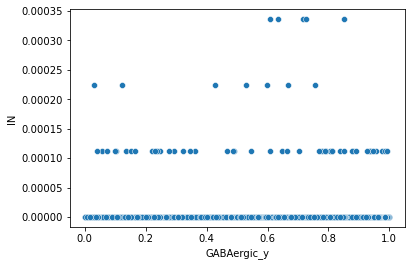

In [143]:
ax = sns.scatterplot(x=(df_cre_tog_sel['GABAergic_y']), y=df_cre_tog_sel['EX'], )

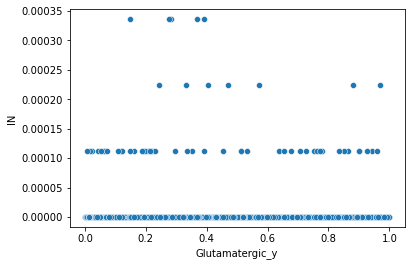

In [142]:
ax = sns.scatterplot(x=(df_cre_tog_sel['Glutamatergic_y']), y=df_cre_tog_sel['IN'], )
#ax.set_xlim([-0.0005,0.05])

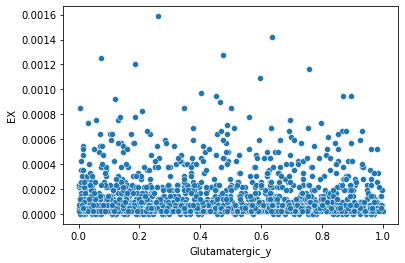

In [144]:
ax = sns.scatterplot(x=(df_cre_tog_sel['Glutamatergic_y']), y=df_cre_tog_sel['EX'], )
#ax.set_xlim([-0.0005,0.05])

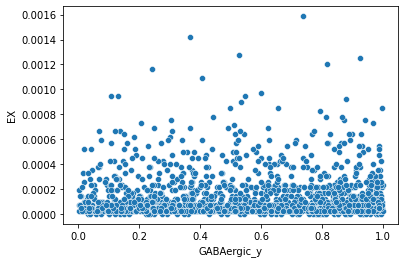

In [145]:
ax = sns.scatterplot(x=(df_cre_tog_sel['GABAergic_y']), y=df_cre_tog_sel['EX'], )
#ax.set_xlim([-0.0005,0.05])

In [146]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
from scipy.stats import mannwhitneyu
import h5py


SRP_name = 'aggregates'
resolution = '1kbp_raw' 
species= 'mouse'


def calc_auroc (df_trial,predicted_score='predicted_score'):
    df_trial = df_trial.sort_values(by=[predicted_score], ascending=False)
    rank_abs = lambda x: stats.rankdata(x)
    predicts2 = np.apply_along_axis(rank_abs, 0, df_trial[predicted_score].values)
    df_trial['p'] = [y if x==1 else 0 for x,y in zip(df_trial['true_pos'], predicts2)]
    #print (df_trial['p'].sum())
    if df_trial['true_neg'].sum() == 0 or df_trial['true_pos'].sum() == 0:
        return np.nan
    else:
        return (((df_trial['p'].sum() /df_trial['true_pos'].sum() )- (df_trial['true_pos'].sum() + 1)/2)) / df_trial['true_neg'].sum()


exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/spr/hic_gene_corr_inter_excluding_intra_chrom_pairs_hicexp.h5'
jac_sim_spr = hm.hiCMatrix(exp_file_path)
all_genes_spr = [x[3].decode() for x in jac_sim_spr.cut_intervals]
df_jac_corr = pd.DataFrame(jac_sim_spr.matrix.toarray() ,  index=all_genes_spr, columns = all_genes_spr)
  

input_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/'
bins_bed = pd.read_csv(f'{input_path}/all_bins.bed', names=['chr', 'start', 'end', 'bin_id'])
bins_bed['bin_id'] = bins_bed.index
  
chr_list = bins_bed.drop_duplicates(subset=['chr'])['chr'].tolist()
chrom_index_list = {}
for chrom in chr_list:
      st = bins_bed[bins_bed['chr'] == chrom]['bin_id'].tolist()[0]
      en = bins_bed[bins_bed['chr'] == chrom]['bin_id'].tolist()[-1]
      chrom_index_list[chrom] = list(range(st, en+1))
gene_bed = pd.read_csv(f'{input_path}/all_gene.bed', names=['chr', 'start_bin', 'end_bin', 'gene'])



marker_list = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/biccn_cluster_markers.csv')

all_markers_df = []
for marker_type in ['class', 'subclass', 'cluster']:
	marker_list = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/biccn_{marker_type}_markers.csv')
	all_markers_df.append(marker_list)

marker_list = pd.concat(all_markers_df)
marker_list = marker_list.drop_duplicates(subset=['gene'])
df_ensg_name = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/mouse_geneid_symbol.txt',sep='\t', names=['gene_id', 'gene'])
#df_ensg_name['gene'] = df_ensg_name['gene'].str.upper()
marker_list = marker_list.merge(df_ensg_name.drop_duplicates(subset=['gene']), right_on='gene', left_on='gene') 
#df_ensg_name = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/ensg_geneid_symbol.csv', sep='\t')[['Ensembl_gene_identifier', 'Symbol']]
#marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
#marker_list = marker_list.drop_duplicates(subset=['Ensembl_gene_identifier'])
marker_list = marker_list.drop_duplicates(subset=['gene_id'])



with h5py.File(f'{input_path}/hic_gene_gw_none_by_allbins_none.h5', 'r') as hf:
        tot_g = (list(hf.keys()))

all_background_markers = list(set(all_genes_spr) -  set(marker_list['gene_id'].tolist())) + marker_list['gene_id'].tolist()
all_background_markers = marker_list['gene_id'].tolist()
#all_background_markers = marker_list['cell_type'] != Non-Neuronal['gene_id'].tolist()

marker_contacts_list_inter = []

gene_list = []
with h5py.File(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/hic_gene_gw_none_by_allbins_none.h5', 'r') as hf:
                   
                   for key in all_background_markers:
                    if key in tot_g:
                            gene_list.append(key)
                            gene_chrom = gene_bed[gene_bed['gene'] == key]['chr'].values[0]
                            #which ever chrom the gene falls into, those bins should be nan
                            my_data = hf[key][()]
                            my_data = my_data.astype('float64')
                            my_data[chrom_index_list[gene_chrom]] = np.nan
                            marker_contacts_list_inter.append(my_data)
                            
                            
my_data = np.array(marker_contacts_list_inter)

df_max_gene_inter_by_bins = pd.DataFrame(my_data, index=gene_list, columns = bins_bed['bin_id'].tolist())

df_max_gene_inter_by_bins_normalized = df_max_gene_inter_by_bins.div(df_max_gene_inter_by_bins.mean(axis=1, skipna=True), axis=0)
df_max_gene_inter_by_bins = df_max_gene_inter_by_bins_normalized

df_max_gene_inter_by_bins_sum = df_max_gene_inter_by_bins.sum().reset_index()

df_max_gene_inter_by_bins_sum_mean = df_max_gene_inter_by_bins.mean().reset_index()

#outfile_name = f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/background_sum_gene_nor_all_back.csv'
#df_max_gene_inter_by_bins_sum.to_csv(outfile_name, index=False)
#outfile_name = f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/background_mean_gene_nor_all_back.csv'
#df_max_gene_inter_by_bins_sum_mean.to_csv(outfile_name, index=False)


import os
number_of_genes_list = [ 1000, 'opt', 10, 200]
number_of_genes_list = [ 1000 ]
marker_level_list = ['class', 'subclass', 'cluster']
marker_level_list = ['class']

for number_of_genes in number_of_genes_list:
    for marker_level in marker_level_list:
        
        marker_list = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/biccn_{marker_level}_markers.csv')
        df_ensg_name = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/mouse_geneid_symbol.txt',sep='\t', names=['gene_id', 'gene'])
        #df_ensg_name['gene'] = df_ensg_name['gene'].str.upper()
        marker_list = marker_list.merge(df_ensg_name.drop_duplicates(subset=['gene']), right_on='gene', left_on='gene') 

        #marker_list = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/{species}/{marker_level}_markers_top1000.csv.gz', skiprows=1)
        #df_ensg_name = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/ensg_geneid_symbol.csv', sep='\t')[['Ensembl_gene_identifier', 'Symbol']]
        #marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
        #marker_list = marker_list[marker_list['gene_id'].isin(all_genes_spr)]
        marker_list = marker_list[marker_list['gene_id'].isin(tot_g)]
        
        #marker_list = marker_list[marker_list['rank'] < number_of_genes]
        all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
        df2_list = []
                    

                
        for group2 in all_cell_types:
            
            if number_of_genes == 'opt':
            
                number_of_marker = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/optimal_number_markers.csv').sort_values(by=['f1']).drop_duplicates(subset=['marker_set'], keep='last')

                try:
                    number_of_genes_optimal = number_of_marker[number_of_marker['marker_set'] == group2]['n_genes'].values[0]
                except:
                    number_of_genes_optimal = 0
                df2_list.append(marker_list[((marker_list['cell_type']==group2) & (marker_list['rank']<=number_of_genes_optimal))])
            else:
                df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes))

        marker_list=pd.concat(df2_list)

        marker_table = marker_list.pivot_table(index='gene_id', columns='cell_type', values='rank', aggfunc='sum')

        marker_table.fillna(0, inplace=True)
                    
        marker_table[marker_table != 0] = 1

        all_markers = marker_table.index.tolist()
                    


        marker_list = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/biccn_{marker_level}_markers.csv')
        marker_list_types = marker_list.drop_duplicates(subset=['cell_type'])['cell_type'].tolist()   
        marker_list_groups = marker_list.drop_duplicates(subset=['cell_type'])['group'].tolist()   
        df_list_mean = []

        cell_type_list_order = []
        


        for group, cell_type in zip(marker_list_groups, marker_list_types):
            
            try:
            
            
                marker_genes_group = marker_table[marker_table[cell_type] == 1].index.tolist()

                df_tmp = df_max_gene_inter_by_bins.loc[marker_genes_group, :].mean(skipna=True).reset_index()

                df_tmp= df_tmp.set_index('index')
                df_tmp.rename(columns = {0:'mean_cell_type'}, inplace = True)

                d2 = df_tmp[['mean_cell_type']].T
                cell_type_list_order.append(cell_type)
                #d2['cell_type'] = cell_type
                #d2['subclass'] = group
                #d2['class'] = class_dict[group]

                df_list_mean.append(d2)
            except:
                pass
            #print (cell_type)
            
        df_concat_list_mean_nn = pd.concat(df_list_mean)
        column_list = df_concat_list_mean_nn.columns.tolist()
        print (number_of_genes)

        from umap import UMAP
        import plotly.express as px

        df = df_concat_list_mean_nn.dropna(axis=1)


        features = df

        umap_2d = UMAP(n_components=2, init='random', random_state=0)


        proj_2d = umap_2d.fit_transform(features)


        j = df_concat_list_mean_nn.to_numpy()
        
        

        outfile_name = f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/{marker_level}_{number_of_genes}_contacts_gene_nor_all_back.h5'
        
        if os.path.isfile(outfile_name):
            os.remove(outfile_name)
        
        with h5py.File(outfile_name, 'a') as hf:
                            


            hf.create_dataset('type_contacts',data=j)
            hf.create_dataset('type_list',data=cell_type_list_order)
            hf.create_dataset('column_list',data=column_list)
            

            

        outfile_name = f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/{marker_level}_{number_of_genes}_proj_2d_gene_nor_all_back.h5'
        
        if os.path.isfile(outfile_name):
            os.remove(outfile_name)
        with h5py.File(outfile_name, 'a') as hf:
                            

            hf.create_dataset('proj_2d',data=proj_2d)
            hf.create_dataset('type_list',data=cell_type_list_order)
            
import os
from scipy.stats import mannwhitneyu


number_of_genes_list = [1000, 800, 500]
marker_level_list = ['class']
#number_of_genes_list = [ 1000, 'opt', 10, 200]
#marker_level_list = ['class', 'subclass', 'cluster']
for number_of_genes in number_of_genes_list:
    for marker_level in marker_level_list:
        
        marker_list = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/biccn_{marker_level}_markers.csv')
        df_ensg_name = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/mouse_geneid_symbol.txt',sep='\t', names=['gene_id', 'gene'])
        #df_ensg_name['gene'] = df_ensg_name['gene'].str.upper()
        marker_list = marker_list.merge(df_ensg_name.drop_duplicates(subset=['gene']), right_on='gene', left_on='gene') 

        #marker_list = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/{species}/{marker_level}_markers_top1000.csv.gz', skiprows=1)
        #df_ensg_name = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/ensg_geneid_symbol.csv', sep='\t')[['Ensembl_gene_identifier', 'Symbol']]
        #marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
        #marker_list = marker_list[marker_list['gene_id'].isin(all_genes_spr)]
        marker_list = marker_list[marker_list['gene_id'].isin(tot_g)]
        #marker_list = marker_list[marker_list['rank'] < number_of_genes]
        all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
        df2_list = []
                    

                
        for group2 in all_cell_types:
                df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes))

        marker_list=pd.concat(df2_list)

        marker_table = marker_list.pivot_table(index='gene_id', columns='cell_type', values='rank', aggfunc='sum')

        marker_table.fillna(0, inplace=True)
                    
        marker_table[marker_table != 0] = 1

        all_markers = marker_table.index.tolist()
                    


        marker_list = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/biccn_{marker_level}_markers.csv')
        marker_list_types = marker_list.drop_duplicates(subset=['cell_type'])['cell_type'].tolist()   
        marker_list_groups = marker_list.drop_duplicates(subset=['cell_type'])['group'].tolist()   
        df_list_mean = []

        cell_type_list_order = []
        
        df_list_p_val = []
        
        #all_cell_types  = ['Glutamatergic', 'GABAergic']

        for group, cell_type in zip(marker_list_groups, marker_list_types):
            for cell_type_2 in marker_list_types:
                
                if cell_type != cell_type_2:
            
            
            
                    marker_genes_group = marker_table[marker_table[cell_type] == 1].index.tolist()

                    df_max_gene_whole_group_1 = df_max_gene_inter_by_bins.loc[marker_genes_group, :]

                    marker_genes_group = marker_table[marker_table[cell_type] != 1].index.tolist()

                    df_max_gene_whole_group_2 = df_max_gene_inter_by_bins.loc[marker_genes_group, :]

                    def addData(x):
                        try:
                            U, p_val = mannwhitneyu(x.dropna().tolist(), df_max_gene_whole_group_2[x.name].dropna().tolist(), alternative="greater")
                            return p_val
                        except:
                            return np.nan


                    new_df = df_max_gene_whole_group_1.apply(addData)
                    df_list_p_val.append(new_df)
                    cell_type_list_order.append(cell_type)
                    column_list = df_max_gene_whole_group_1.columns.tolist()
                    j = new_df.to_numpy()
                    cell_type_name = cell_type.replace('/', "_")
                    outfile_name = f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/{marker_level}_{number_of_genes}_p_val_gene_nor_all_back_{cell_type}_vs_remaining_class.h5'

                    if os.path.isfile(outfile_name):
                        os.remove(outfile_name)

                    with h5py.File(outfile_name, 'a') as hf:



                        hf.create_dataset('type_contacts',data=j)
                        hf.create_dataset('type_list',data=cell_type)
                        hf.create_dataset('type_list_2',data=cell_type_2)
                        hf.create_dataset('column_list',data=column_list)


                        
                        
number_of_genes_list = [800, 500]
marker_level_list = ['class']
#number_of_genes_list = [ 1000, 'opt', 10, 200]
#marker_level_list = ['class', 'subclass', 'cluster']
for number_of_genes in number_of_genes_list:
    for marker_level in marker_level_list:
        
        marker_list = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/biccn_{marker_level}_markers.csv')
        df_ensg_name = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/mouse_geneid_symbol.txt',sep='\t', names=['gene_id', 'gene'])
        #df_ensg_name['gene'] = df_ensg_name['gene'].str.upper()
        marker_list = marker_list.merge(df_ensg_name.drop_duplicates(subset=['gene']), right_on='gene', left_on='gene') 

        #marker_list = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/{species}/{marker_level}_markers_top1000.csv.gz', skiprows=1)
        #df_ensg_name = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/ensg_geneid_symbol.csv', sep='\t')[['Ensembl_gene_identifier', 'Symbol']]
        #marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
        #marker_list = marker_list[marker_list['gene_id'].isin(all_genes_spr)]
        marker_list = marker_list[marker_list['gene_id'].isin(tot_g)]
        #marker_list = marker_list[marker_list['rank'] < number_of_genes]
        all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
        df2_list = []
                    

                
        for group2 in all_cell_types:
                df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes))

        marker_list=pd.concat(df2_list)

        marker_table = marker_list.pivot_table(index='gene_id', columns='cell_type', values='rank', aggfunc='sum')

        marker_table.fillna(0, inplace=True)
                    
        marker_table[marker_table != 0] = 1

        all_markers = marker_table.index.tolist()
                    


        marker_list = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/biccn_{marker_level}_markers.csv')
        marker_list_types = marker_list.drop_duplicates(subset=['cell_type'])['cell_type'].tolist()   
        marker_list_groups = marker_list.drop_duplicates(subset=['cell_type'])['group'].tolist()   
        df_list_mean = []

        cell_type_list_order = []
        
        df_list_p_val = []
        
        #all_cell_types  = ['Glutamatergic', 'GABAergic']

        for group, cell_type in zip(marker_list_groups, marker_list_types):
            for cell_type_2 in marker_list_types:
                
                if cell_type != cell_type_2:
            
            
            
                    marker_genes_group = marker_table[marker_table[cell_type] == 1].index.tolist()

                    df_max_gene_whole_group_1 = df_max_gene_inter_by_bins.loc[marker_genes_group, :]

                    marker_genes_group = marker_table[marker_table[cell_type_2] == 1].index.tolist()

                    df_max_gene_whole_group_2 = df_max_gene_inter_by_bins.loc[marker_genes_group, :]

                    def addData(x):
                        try:
                            U, p_val = mannwhitneyu(x.dropna().tolist(), df_max_gene_whole_group_2[x.name].dropna().tolist(), alternative="greater")
                            return p_val
                        except:
                            return np.nan


                    new_df = df_max_gene_whole_group_1.apply(addData)
                    df_list_p_val.append(new_df)
                    cell_type_list_order.append(cell_type)
                    column_list = df_max_gene_whole_group_1.columns.tolist()
                    j = new_df.to_numpy()
                    cell_type_name = cell_type.replace('/', "_")
                    outfile_name = f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/{marker_level}_{number_of_genes}_p_val_gene_nor_all_back_{cell_type}_vs_{cell_type_2}_class.h5'

                    if os.path.isfile(outfile_name):
                        os.remove(outfile_name)

                    with h5py.File(outfile_name, 'a') as hf:



                        hf.create_dataset('type_contacts',data=j)
                        hf.create_dataset('type_list',data=cell_type)
                        hf.create_dataset('type_list_2',data=cell_type_2)
                        hf.create_dataset('column_list',data=column_list)
                        
                        

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


1000


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
  File "/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/pandas/core/generic.py", line 5477, in __setattr__
    object.__getattribute__(self, name)
  File "/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/pandas/core/series.py", line 536, in name
    return self._name
  File "/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/pandas/core/generic.py", line 5461, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'Series' object has no attribute '_name'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-146-d7dca32b7b70>", line 315, in <module>
    new_df = df_max_gene_whole_group_

TypeError: object of type 'NoneType' has no len()

In [148]:
import os
from scipy import stats


number_of_genes_list = [1000]
marker_level_list = ['class']
#number_of_genes_list = [ 1000, 'opt', 10, 200]
#marker_level_list = ['class', 'subclass', 'cluster']
for number_of_genes in number_of_genes_list:
    for marker_level in marker_level_list:
        
        marker_list = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/biccn_{marker_level}_markers.csv')
        df_ensg_name = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/mouse_geneid_symbol.txt',sep='\t', names=['gene_id', 'gene'])
        #df_ensg_name['gene'] = df_ensg_name['gene'].str.upper()
        marker_list = marker_list.merge(df_ensg_name.drop_duplicates(subset=['gene']), right_on='gene', left_on='gene') 

        #marker_list = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/{species}/{marker_level}_markers_top1000.csv.gz', skiprows=1)
        #df_ensg_name = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/ensg_geneid_symbol.csv', sep='\t')[['Ensembl_gene_identifier', 'Symbol']]
        #marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
        #marker_list = marker_list[marker_list['gene_id'].isin(all_genes_spr)]
        marker_list = marker_list[marker_list['gene_id'].isin(tot_g)]
        #marker_list = marker_list[marker_list['rank'] < number_of_genes]
        all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
        df2_list = []
                    

                
        for group2 in all_cell_types:
                df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes))

        marker_list=pd.concat(df2_list)

        marker_table = marker_list.pivot_table(index='gene_id', columns='cell_type', values='rank', aggfunc='sum')

        marker_table.fillna(0, inplace=True)
                    
        marker_table[marker_table != 0] = 1

        all_markers = marker_table.index.tolist()
                    


        marker_list = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/biccn_{marker_level}_markers.csv')
        marker_list_types = marker_list.drop_duplicates(subset=['cell_type'])['cell_type'].tolist()   
        marker_list_groups = marker_list.drop_duplicates(subset=['cell_type'])['group'].tolist()   
        df_list_mean = []

        cell_type_list_order = []
        
        df_list_p_val = []
        
        #all_cell_types  = ['Glutamatergic', 'GABAergic']

        for group, cell_type in zip(marker_list_groups, marker_list_types):
            if cell_type == 'Non-Neuronal':
                    print (cell_type)
            

            
            
            
                    marker_genes_group = marker_table[marker_table[cell_type] == 1].index.tolist()

                    df_max_gene_whole_group_1 = df_max_gene_inter_by_bins.loc[marker_genes_group, :]

                    marker_genes_group = marker_table[marker_table[cell_type] != 1].index.tolist()

                    df_max_gene_whole_group_2 = df_max_gene_inter_by_bins.loc[marker_genes_group, :]

                    def addData(x):
                        try:
                            U, p_val = stats.ttest_ind(x.dropna().tolist(), df_max_gene_whole_group_2[x.name].dropna().tolist(), alternative="greater")
                            return p_val
                        except:
                            return np.nan


                    new_df = df_max_gene_whole_group_1.apply(addData)
                    df_list_p_val.append(new_df)
                    cell_type_list_order.append(cell_type)
                    column_list = df_max_gene_whole_group_1.columns.tolist()
                    j = new_df.to_numpy()
                    cell_type_name = cell_type.replace('/', "_")
                    outfile_name = f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/{marker_level}_{number_of_genes}_p_val_gene_nor_all_back_{cell_type}_vs_remaining_class_ttest.h5'

                    if os.path.isfile(outfile_name):
                        os.remove(outfile_name)

                    with h5py.File(outfile_name, 'a') as hf:



                        hf.create_dataset('type_contacts',data=j)
                        hf.create_dataset('type_list',data=cell_type)
                        hf.create_dataset('type_list_2',data='remaining')
                        hf.create_dataset('column_list',data=column_list)


                        
                        


Non-Neuronal


In [147]:
all_cell_types

['GABAergic', 'Non-Neuronal', 'Glutamatergic']

In [150]:
number_of_genes_list = [1000]
marker_level_list = ['subclass']
#number_of_genes_list = [ 1000, 'opt', 10, 200]
#marker_level_list = ['class', 'subclass', 'cluster']
for number_of_genes in number_of_genes_list:
    for marker_level in marker_level_list:
        
        marker_list = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/biccn_{marker_level}_markers.csv')
        df_ensg_name = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/mouse_geneid_symbol.txt',sep='\t', names=['gene_id', 'gene'])
        #df_ensg_name['gene'] = df_ensg_name['gene'].str.upper()
        marker_list = marker_list.merge(df_ensg_name.drop_duplicates(subset=['gene']), right_on='gene', left_on='gene') 

        #marker_list = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/{species}/{marker_level}_markers_top1000.csv.gz', skiprows=1)
        #df_ensg_name = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/ensg_geneid_symbol.csv', sep='\t')[['Ensembl_gene_identifier', 'Symbol']]
        #marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
        #marker_list = marker_list[marker_list['gene_id'].isin(all_genes_spr)]
        marker_list = marker_list[marker_list['gene_id'].isin(tot_g)]
        #marker_list = marker_list[marker_list['rank'] < number_of_genes]
        all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
        df2_list = []
                    

                
        for group2 in all_cell_types:
                df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes))

        marker_list=pd.concat(df2_list)

        marker_table = marker_list.pivot_table(index='gene_id', columns='cell_type', values='rank', aggfunc='sum')

        marker_table.fillna(0, inplace=True)
                    
        marker_table[marker_table != 0] = 1

        all_markers = marker_table.index.tolist()
                    


        marker_list = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/biccn_{marker_level}_markers.csv')
        marker_list_types = marker_list.drop_duplicates(subset=['cell_type'])['cell_type'].tolist()   
        marker_list_groups = marker_list.drop_duplicates(subset=['cell_type'])['group'].tolist()   
        df_list_mean = []

        cell_type_list_order = []
        
        df_list_p_val = []
        
        #all_cell_types  = ['Glutamatergic', 'GABAergic']

        for group, cell_type in zip(marker_list_groups, marker_list_types):
            for cell_type_2 in marker_list_types:
                
                
                
                 if cell_type != cell_type_2:
                  if ((cell_type == 'Sst') & (cell_type_2 == 'Vip')):
            
            
            
                    marker_genes_group = marker_table[marker_table[cell_type] == 1].index.tolist()

                    df_max_gene_whole_group_1 = df_max_gene_inter_by_bins.loc[marker_genes_group, :]

                    marker_genes_group = marker_table[marker_table[cell_type_2] == 1].index.tolist()

                    df_max_gene_whole_group_2 = df_max_gene_inter_by_bins.loc[marker_genes_group, :]

                    def addData(x):
                        try:
                            U, p_val = stats.mannwhitneyu(x.dropna().tolist(), df_max_gene_whole_group_2[x.name].dropna().tolist(), alternative="greater")
                            return p_val
                        except:
                            return np.nan


                    new_df = df_max_gene_whole_group_1.apply(addData)
                    df_list_p_val.append(new_df)
                    cell_type_list_order.append(cell_type)
                    column_list = df_max_gene_whole_group_1.columns.tolist()
                    j = new_df.to_numpy()
                    cell_type_name = cell_type.replace('/', "_")
                    outfile_name = f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/{marker_level}_{number_of_genes}_p_val_gene_nor_all_back_{cell_type}_vs_{cell_type_2}_subclass.h5'

                    if os.path.isfile(outfile_name):
                        os.remove(outfile_name)

                    with h5py.File(outfile_name, 'a') as hf:



                        hf.create_dataset('type_contacts',data=j)
                        hf.create_dataset('type_list',data=cell_type)
                        hf.create_dataset('type_list_2',data=cell_type_2)
                        hf.create_dataset('column_list',data=column_list)
                        
                        